In [ ]:
!pip install tensorly
!pip install sporco

!apt-get install ffmpeg

# Get video duration using FFprobe
import subprocess
import json
import torch
import torchvision.transforms as transforms
from google.colab.patches import cv2_imshow
import os
import cv2
import numpy as np
import tifffile
import torch
from tqdm import tqdm
from sporco import cupy
if cupy.have_cupy:
    from sporco.cupy.admm.rpca import RobustPCA as RPCA_sporco_gpu
from sporco.admm.rpca import RobustPCA as RPCA_sporco
from torch.nn import functional as F
import tensorly as tl
import numpy as np
import torch
from tensorly import backend as T
from tensorly.base import fold, unfold
from tensorly.tenalg.proximal import soft_thresholding, svd_thresholding
import torch
import matplotlib.pyplot as plt
from RTPCA import RTPCA


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


In [ ]:
# Get video duration using FFprobe
import subprocess
import json
import torch
import torchvision.transforms as transforms
from google.colab.patches import cv2_imshow
import cv2
import numpy as np




class Read_and_Edit_Clip:
    def __init__(self,video_path):
        self.video_path = video_path
    def read_clip(self):
        # Open the video file
        self.cap = cv2.VideoCapture(self.video_path)
        # Select a frame number to display (for example, the 100th frame)
        self.frame_number_to_display = 120
        # Set the frame position to the selected frame
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, self.frame_number_to_display)
        # Read the selected frame
        ret, self.frame = self.cap.read()
        # Display the frame
        cv2_imshow( self.frame)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        # Display the resolution of the selected frame
        self.height, self.width, _ = self.frame.shape
        # Release the video capture object
        self.cap.release()
        # Convert the NumPy array to a PyTorch tensor
        self.frame_tensor = transforms.ToTensor()(self.frame)
        # Individual dimensions
        self.channels, self.height, self.width = self.frame_tensor.shape
    def show_information(self):
        print("Channels:", self.channels)
        print("Height:", self.height)
        print("Width:", self.width)
        print(f"Resolution of Frame {self.frame_number_to_display}: {self.width}xself.{self.height}")
        print("Tensor Shape (dimensions):", self.frame_tensor.shape)

    def change_greay_mode(self):
        # Convert the frame to black and white (grayscale)
        gray_frame = cv2.cvtColor( self.frame, cv2.COLOR_BGR2GRAY)
        # Convert the NumPy array to a PyTorch tensor
        frame_tensor = transforms.ToTensor()(gray_frame)
        # Display the black and white frame
        cv2_imshow( gray_frame)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        # Release the video capture object
        self.cap.release()


    def add_salt_and_pepper_noise(self,image, salt_prob, pepper_prob):
        noisy_image = np.copy(image)
        total_pixels = image.size

        # Add salt noise
        num_salt = np.ceil(salt_prob * total_pixels)
        salt_coordinates = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
        noisy_image[salt_coordinates[0], salt_coordinates[1]] = 1

        # Add pepper noise
        num_pepper = np.ceil(pepper_prob * total_pixels)
        pepper_coordinates = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
        noisy_image[pepper_coordinates[0], pepper_coordinates[1]] = 0

        return noisy_image

    def add_noise(self):
        # Read the video
        cap = cv2.VideoCapture(self.video_path)
        # Check if the video file is opened successfully
        if not cap.isOpened():
            print("Error: Could not open video.")
            exit()
        # Get video details
        frame_width = int(cap.get(3))
        frame_height = int(cap.get(4))
        fps = cap.get(5)
        self.noise_clip = "output_video.avi"
        # Create VideoWriter object to save the output video
        out = cv2.VideoWriter(self.noise_clip, cv2.VideoWriter_fourcc(*'XVID'), fps, (frame_width, frame_height))
        while cap.isOpened():
            ret, frame = cap.read()

            if not ret:
                break
            # Convert the frame to grayscale
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            # Add salt-and-pepper noise to the grayscale frame
            noisy_gray_frame = self.add_salt_and_pepper_noise(gray_frame, salt_prob=0.01, pepper_prob=0.01)
            # Convert grayscale frame back to RGB
            noisy_frame = cv2.cvtColor(gray_frame, cv2.COLOR_GRAY2BGR)
            # Write the frame to the output video
            out.write(noisy_frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        # Release the video capture and writer objects
        cap.release()
        out.release()

        # Close all OpenCV windows
        cv2.destroyAllWindows()

    def video_compressore(self):

        # Use FFmpeg to compress the video
        input_video_path = self.noise_clip
        self.compress_with_noise = 'output_video_compressed.avi'
        output_video_path = 'output_video_compressed.avi'

        !ffmpeg -i {input_video_path} -c:v libx264 -crf 23 -preset medium -c:a aac -b:a 128k {output_video_path}
    def Split_Clip(self):

        input_video_path = self.compress_with_noise

        # Run FFprobe to get video information in JSON format
        ffprobe_cmd = f'ffprobe -v quiet -print_format json -show_format -show_streams {input_video_path}'
        info_json = subprocess.check_output(ffprobe_cmd, shell=True).decode('utf-8')
        video_info = json.loads(info_json)

        # Extract video duration
        self.video_duration = float(video_info['format']['duration'])

        # Calculate split points based on duration
        split_point = self.video_duration / 2  # Split the video into two equal parts

        # Output video paths
        first_clip = 'output_video_part1.avi'
        second_clip = 'output_video_part2.avi'

        # Use FFmpeg to split the video into two parts
        !ffmpeg -i {input_video_path} -t {split_point} -c copy {first_clip}
        !ffmpeg -i {input_video_path} -ss {split_point} -c copy {second_clip}

        return first_clip, second_clip


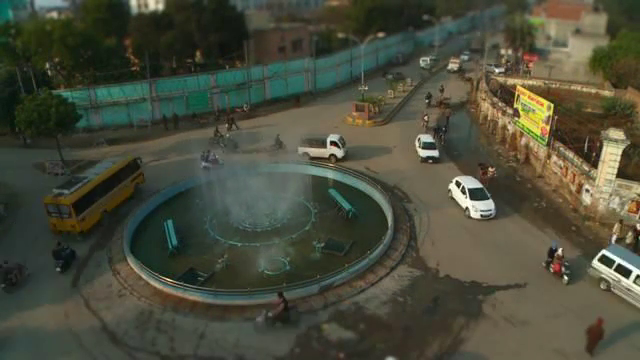

In [ ]:
clip_editor = Read_and_Edit_Clip('/content/Indiantraffic.avi')
clip_editor.read_clip()

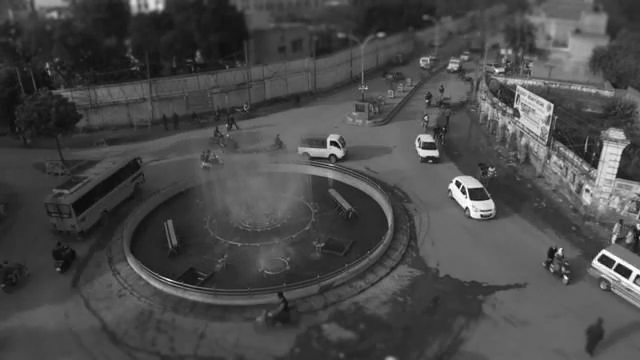

In [ ]:
clip_editor.change_greay_mode()

In [ ]:
clip_editor.show_information()

Channels: 3
Height: 360
Width: 640
Resolution of Frame 120: 640xself.360
Tensor Shape (dimensions): torch.Size([3, 360, 640])


In [ ]:
clip_editor.add_noise()

In [ ]:
clip_editor.video_compressore()

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [ ]:
spilited_video_path = clip_editor.Split_Clip()

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [ ]:
program = RTPCA(video_path = spilited_video_path[0],reg_E=0.002, n_iter_max=200, backend='pytorch')  # pytorch
program.run()




[INFO] iter: 0  error: 6795.763386110515
[INFO] iter: 1  error: 6795.763386110515
[INFO] iter: 2  error: 6632.988569794705
[INFO] iter: 3  error: 4768.5664986554675
[INFO] iter: 4  error: 2982.0034850983698
[INFO] iter: 5  error: 2588.1830398214474
[INFO] iter: 6  error: 2899.9373075997655
[INFO] iter: 7  error: 2828.3977534395476
[INFO] iter: 8  error: 2431.0098769092583
[INFO] iter: 9  error: 2066.9699033850625
[INFO] iter: 10  error: 1909.416036304032
[INFO] iter: 11  error: 1849.8782676360713
[INFO] iter: 12  error: 1730.789360178792
[INFO] iter: 13  error: 1476.590258935631
[INFO] iter: 14  error: 1258.7985071695916
[INFO] iter: 15  error: 1130.6618471759325
[INFO] iter: 16  error: 1050.43293381967
[INFO] iter: 17  error: 970.5371730038149
[INFO] iter: 18  error: 883.7209955686972
[INFO] iter: 19  error: 801.7845616559968
[INFO] iter: 20  error: 725.1197592987477
[INFO] iter: 21  error: 664.5730573997656
[INFO] iter: 22  error: 606.2733747326997
[INFO] iter: 23  error: 556.0652433